# TESTS for correlations functions

In [1]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u

## Open a test data

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [3]:
cosmo = extragalactic_cat.cosmology

In [4]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec', 'halo_id'],\
                                                 filters=['halo_mass > 0.5e13','is_central==True','redshift>0.20', 'redshift<0.5'])

mass_list = massive_halos['halo_mass']
select = (mass_list == mass_list)


In [5]:
mass_list.size

85207

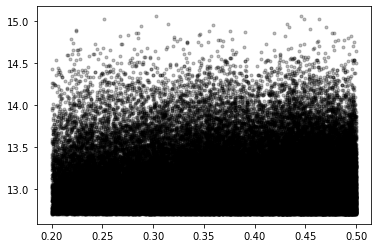

In [6]:
plt.plot(massive_halos['redshift'], np.log10(massive_halos['halo_mass']),'k.',alpha=0.25)

In [7]:
#DC2 full
filters = ['mag_i_lsst<26.','(mag_u_lsst - mag_g_lsst) > 1.4 ', '(mag_r_lsst - mag_i_lsst) < 0.28 ', 'ra>50', 'ra<74', 'dec<-27', 'dec>-45'] 

gal_selection = extragalactic_cat.get_quantities(['mag_i_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_1', 'convergence'],\
                                                 filters=filters)

In [ ]:
#DC2 full
filters_hz = ['mag_i_lsst<25.','redshift>1.4','redshift<1.6', 'ra>50', 'ra<74', 'dec<-27', 'dec>-45'] 

gal_selection_hz = extragalactic_cat.get_quantities(['mag_i_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_1', 'convergence'],\
                                                 filters=filters_hz)

In [ ]:
#DC2 full
filters_hz = ['mag_i_lsst<25.','redshift>1.4','redshift<1.6', 'ra>50', 'ra<74', 'dec<-27', 'dec>-45'] 

gal_selection_hz = extragalactic_cat.get_quantities(['mag_i_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_1', 'convergence'],\
                                                 filters=filters_hz)

In [164]:
len(gal_selection_hz['ra'])/1e6

2.791567

In [10]:
len(gal_selection['ra'])/1e6

0.32424

In [8]:
gal_cat = Table(gal_selection)



## Create a source catalog

In [20]:
#DC2 small
#selection = ( gal_cat['ra']>62) & ( gal_cat['ra']<67.5) & ( gal_cat['dec']<-36) & ( gal_cat['dec']>-41.8)

In [9]:
#DC2 full
selection = ( gal_cat['ra']>50) & ( gal_cat['ra']<74) & ( gal_cat['dec']<-27.) & ( gal_cat['dec']>-45.)

In [10]:
#selection = ( gal_cat['ra']>0) & ( gal_cat['dec']<0)

In [11]:
#DC2 small
#selection_halo = ( massive_halos['ra']>62) & ( massive_halos['ra']<67.5) & ( massive_halos['dec']<-36) & ( massive_halos['dec']>-41.8)

In [12]:
#DC2 full
selection_halo = ( massive_halos['ra']>50) & ( massive_halos['ra']<74) & ( massive_halos['dec']<-27) & ( massive_halos['dec']>-45)

In [13]:
cat = treecorr.Catalog(ra = gal_cat['ra'][selection], dec = gal_cat['dec'][selection], ra_units='deg', dec_units='deg', g1 = gal_cat['shear_1'][selection], g2 = gal_cat['shear_1'][selection], k = gal_cat['convergence'][selection])

#alternative form : 
#cat = treecorr.Catalog(filename, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg', g1_col='GAMMA1',  g2_col='GAMMA2', k_col='KAPPA')

## Create random source catalog with same area

In [14]:
ra_min = np.min(cat.ra)
ra_max = np.max(cat.ra)
dec_min = np.min(cat.dec)
dec_max = np.max(cat.dec)
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

rand_ra = np.random.uniform(ra_min, ra_max, 10**8)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**8)
rand_dec = np.arcsin(rand_sindec)

ra range = 0.872665 .. 1.291544
dec range = -0.785397 .. -0.471240


In [15]:
rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')

## Plot data and random source catalogs

Text(0.5, 1.0, 'Data on top of randoms')

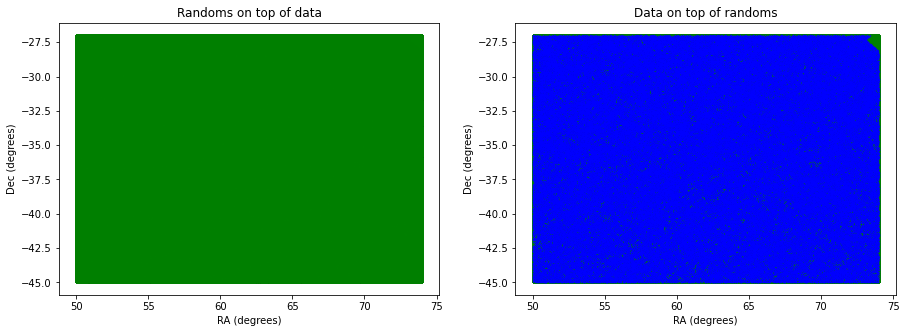

In [16]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(cat.ra * 180/np.pi, cat.dec * 180/np.pi, color='blue', s=0.1)
ax1.scatter(rand.ra * 180/np.pi, rand.dec * 180/np.pi, color='green', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(rand.ra * 180/np.pi, rand.dec * 180/np.pi, color='green', s=0.1)
ax2.scatter(cat.ra * 180/np.pi, cat.dec * 180/np.pi, color='blue', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

#ax2.plot(cat_halo.ra * 180/np.pi, cat_halo.dec * 180/np.pi, 'ro')

## Compute count-count correlation functions on the source catalogs

In [17]:
ss = treecorr.NNCorrelation(min_sep=0.1, max_sep=10,nbins=10, sep_units='arcmin',  bin_type='Log')
ss.process(cat)

In [25]:
rr = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, nbins=10, sep_units='arcmin', bin_type='Log')
rr.process(rand)

In [27]:
sr = treecorr.NNCorrelation(min_sep=0.1, max_sep=10, nbins=10, sep_units='arcmin', bin_type='Log')
sr.process(cat, rand)

###  $\xi = (SS - 2SR + RR)/RR $

In [37]:
xi, varxi = ss.calculateXi(rr, sr)
r = np.exp(ss.meanlogr)
sig = np.sqrt(varxi)

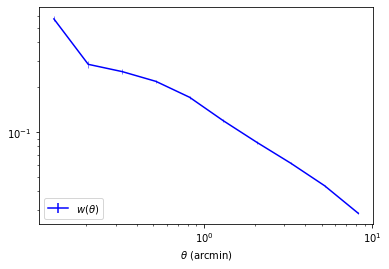

In [38]:
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.show()

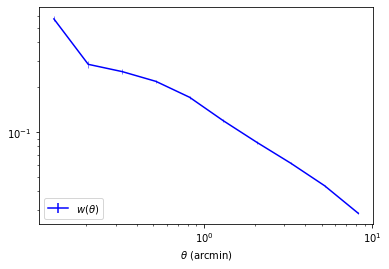

In [39]:
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.show()

## Create lens catalog

In [1]:
#DC2 full
selection_halo = ( massive_halos['ra']>50) & ( massive_halos['ra']<74) & ( massive_halos['dec']<-27) & ( massive_halos['dec']>-45)

NameError: name 'massive_halos' is not defined

In [ ]:
cat_halo = treecorr.Catalog(ra = massive_halos['ra'][selection_halo], dec = massive_halos['dec'][selection_halo], ra_units='deg', dec_units='deg')

## Compute count-count correlation functions between lens catalog and source catalogs

# $w = LS/LR - 1$

In [ ]:
def corr_quantities(cat_halo, cat, rand, rr, rd=sr, bin_dict={'min_sep':0.1, 'max_sep':10, 'sep_units':'arcmin','bin_type':'Log','nbins':10}):
    
    ra_min = np.min(cat_halo.ra)
    ra_max = np.max(cat_halo.ra)
    dec_min = np.min(cat_halo.dec)
    dec_max = np.max(cat_halo.dec)

    rand_ra = np.random.uniform(ra_min, ra_max, np.round(cat_halo.ra.size))
    rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), np.round(cat_halo.ra.size))
    rand_dec = np.arcsin(rand_sindec)
    
    cat_rand_halo = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
    
    ls = treecorr.NNCorrelation(**bin_dict)
    ls.process(cat_halo, cat)
    
    lr = treecorr.NNCorrelation(**bin_dict)
    lr.process(cat_halo, rand)
    
    xi, varxi = ls.calculateXi(rr, lr, rd)
    r = np.exp(ls.meanlogr)
    sigxi = np.sqrt(varxi)
    
    ls_rand = treecorr.NNCorrelation(**bin_dict)
    ls_rand.process(cat_rand_halo, cat)
    
    lr_rand = treecorr.NNCorrelation(**bin_dict)
    lr_rand.process(cat_rand_halo, rand)
    
    xi_rand, varxi_rand = ls_rand.calculateXi(rr, lr_rand, rd)
    r_rand = np.exp(ls_rand.meanlogr)
    sigxi_rand = np.sqrt(varxi_rand)
    
    return r, xi, sigxi, r_rand, xi_rand, sigxi_rand

In [ ]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand):
    fig, ax = plt.subplots(1,1)
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='o')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

In [ ]:
r, xi, sigxi, r_rand, xi_rand, sigxi_rand = corr_quantities(cat_halo, cat, rand, rr, rd=sr, bin_dict={'min_sep':0.1, 'max_sep':10, 'sep_units':'arcmin','bin_type':'Log','nbins':10})

In [ ]:
fig, ax =  corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand)

conv = cosmo.kpc_proper_per_arcmin(massive_halos['redshift'].mean()).to(u.Mpc/u.arcmin)
ax.axvline(2*healpy.nside2resol(4096, arcmin = True)*conv.value, linestyle="dashed")

In [ ]:
lm_cond = massive_halos['halo_mass']<np.median(massive_halos['halo_mass'])
cat_halo_lm = treecorr.Catalog(ra = massive_halos['ra'][selection_halo*lm_cond], dec = massive_halos['dec'][selection_halo*lm_cond], ra_units='deg', dec_units='deg')

In [ ]:
r, xi, sigxi, r_rand, xi_rand, sigxi_rand = corr_quantities(cat_halo_lm, cat, rand, rr, rd=sr, bin_dict={'min_sep':0.1, 'max_sep':10, 'sep_units':'arcmin','bin_type':'Log','nbins':10})

In [ ]:
fig, ax =  corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand)

conv = cosmo.kpc_proper_per_arcmin(massive_halos['redshift'].mean()).to(u.Mpc/u.arcmin)
ax.axvline(2*healpy.nside2resol(4096, arcmin = True)*conv.value, linestyle="dashed")

In [ ]:
um_cond = massive_halos['halo_mass']>=np.median(massive_halos['halo_mass']) * (massive_halos['redshift']<0.3)
cat_halo_um = treecorr.Catalog(ra = massive_halos['ra'][selection_halo*um_cond], dec = massive_halos['dec'][selection_halo*um_cond], ra_units='deg', dec_units='deg')

In [ ]:
r, xi, sigxi, r_rand, xi_rand, sigxi_rand = corr_quantities(cat_halo_um, cat, rand, rr, rd=sr, bin_dict={'min_sep':0.1, 'max_sep':10, 'sep_units':'arcmin','bin_type':'Log','nbins':10})

In [ ]:
fig, ax = corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand)

conv = cosmo.kpc_proper_per_arcmin(massive_halos['redshift'].mean()).to(u.Mpc/u.arcmin)
ax.axvline(2*healpy.nside2resol(4096, arcmin = True)*conv.value, linestyle="dashed")

# $w = \frac{LS - LR - SR +RR}{RR} $ 

 see eq.6 in https://arxiv.org/pdf/1111.3698.pdf

# ANNEXES

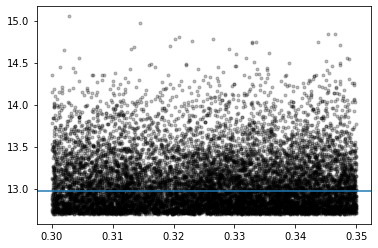

In [216]:
plt.plot(massive_halos['redshift'], np.log10(massive_halos['halo_mass']),'k.',alpha=0.25)

plt.axhline(np.log10(np.median(massive_halos['halo_mass'])))

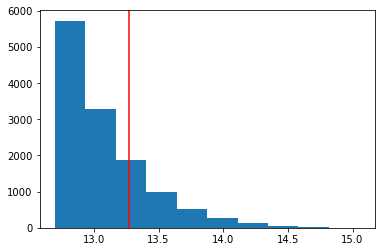

In [32]:
plt.hist(np.log10(massive_halos['halo_mass']))
plt.axvline(np.log10(massive_halos['halo_mass'].mean()),color='red')

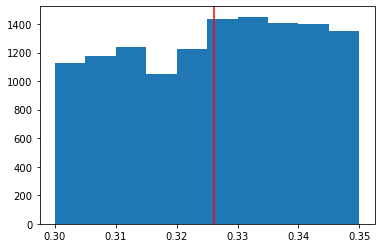

In [33]:
plt.hist(massive_halos['redshift'])
plt.axvline(massive_halos['redshift'].mean(),color='red')

In [34]:
import clmm.modeling as mod
from clmm import utils 

In [54]:
rad_Mpc = utils.convert_units(r_p2, 'arcmin', 'Mpc',  massive_halos['redshift'].mean(), cosmo)

In [198]:
mass_list = np.array([massive_halos['halo_mass'][lm_cond].mean(), massive_halos['halo_mass'].mean(), massive_halos['halo_mass'][um_cond].mean()])

model_magnification=[]

for i in range(3):
    model_magnification.append(mod.predict_magnification(rad_Mpc*cosmo.h, mdelta=mass_list[i]*cosmo.h, 
                                        cdelta=4., z_cluster=massive_halos['redshift'].mean(), z_source=1.5, 
                                        cosmo= mod.cclify_astropy_cosmo(cosmo), 
                                        delta_mdef=200, 
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane')) 

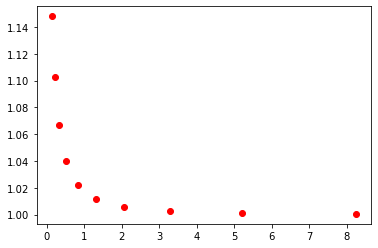

In [37]:
plt.plot(r_p2, model_magnification, 'ro')

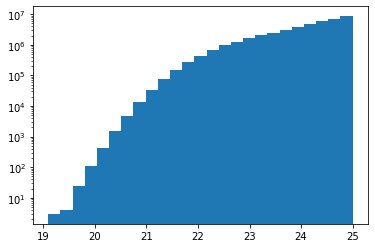

In [149]:
mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=25,cumulative=True);
plt.yscale('log')

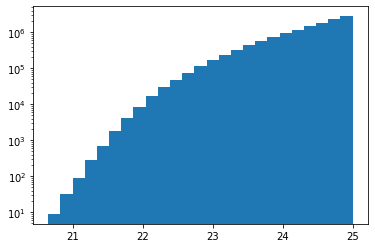

In [189]:
mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=25,cumulative=True);
plt.yscale('log')

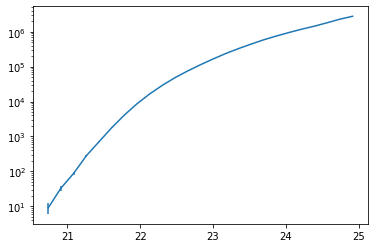

In [192]:
bin_center = mag_hist[1][0:-1]+0.5*(mag_hist[1][1]-mag_hist[1][0])
plt.errorbar(bin_center,mag_hist[0], yerr = np.sqrt(mag_hist[0]))

plt.yscale('log')

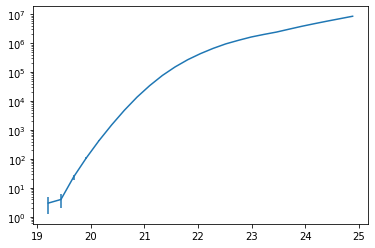

In [151]:
bin_center = mag_hist[1][0:-1]+0.5*(mag_hist[1][1]-mag_hist[1][0])
plt.errorbar(bin_center,mag_hist[0], yerr = np.sqrt(mag_hist[0]))

plt.yscale('log')

In [193]:
from scipy.interpolate import InterpolatedUnivariateSpline

# Get a function that evaluates the linear spline at any x
f = InterpolatedUnivariateSpline(bin_center, np.log10(mag_hist[0]), k=1)

# Get a function that evaluates the derivative of the linear spline at any x
dfdx = f.derivative()

# Evaluate the derivative dydx at each x location...
dydx = dfdx(bin_center)

In [194]:
def d_fun(x):
    h = 1e-5
    return (fun(x+h)-fun(x-h))/(2*h)

In [195]:
test = (np.log10(mag_hist[0])[1:] - np.log10(mag_hist[0])[:-1])/(mag_hist[1][1]-mag_hist[1][0])

(0.9, 2.0)

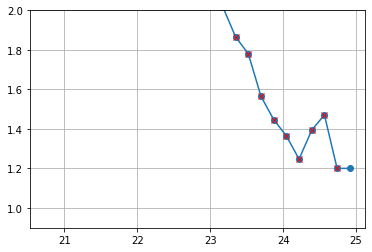

In [197]:
plt.plot(bin_center, dydx*2.5,'-o')

plt.plot(bin_center[:-1], test*2.5, 'rx')

plt.grid()

plt.ylim(0.9,2)

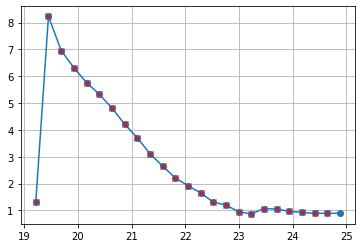

In [159]:
plt.plot(bin_center, dydx*2.5,'-o')

plt.plot(bin_center[:-1], test*2.5, 'rx')

plt.grid()


In [142]:
dydx[-1]*2.5

0.9065535834992768

In [125]:
from magnification_library import *

In [130]:
LF = schechterM(bin_center, 1e3, -1.5, 21.5)

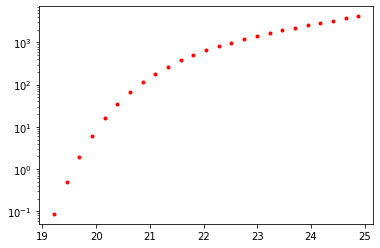

In [131]:
plt.plot(bin_center,LF,'r.')
plt.yscale('log')

In [134]:
from scipy.interpolate import InterpolatedUnivariateSpline

# Get a function that evaluates the linear spline at any x
f = InterpolatedUnivariateSpline(bin_center, np.log10(LF), k=1)

# Get a function that evaluates the derivative of the linear spline at any x
dfdx = f.derivative()

# Evaluate the derivative dydx at each x location...
dydx = dfdx(bin_center)

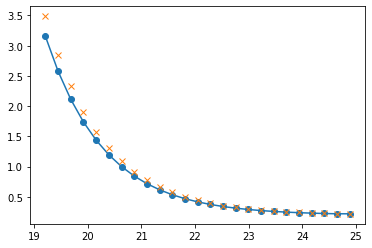

In [137]:
plt.plot(bin_center, dydx,'-o')
plt.plot(bin_center,  slope(bin_center, -1.5, 21.5, beta=None,fct="schechter"),'x')

In [248]:
380*0.9*(1/(u.arcmin*u.arcmin)).to(1/u.deg**2)

<Quantity 1231200. 1 / deg2>